In [1]:
# Example: Custom Layout Pass with NetworkX for VQE or GHZ optimization

from qiskit import QuantumCircuit, transpile
from qiskit.transpiler import CouplingMap, Layout, PassManager, TransformationPass
from qiskit.transpiler import generate_preset_pass_manager
from qiskit.transpiler.passes import SetLayout,VF2Layout
import qiskit_ibm_runtime.fake_provider as fk  # Example IBM device
import networkx as nx
from qiskit.circuit.library import RealAmplitudes
from qiskit.visualization import plot_circuit_layout, plot_coupling_map

In [2]:
import networkx as nx
from qiskit.transpiler import Layout
from qiskit.transpiler import CouplingMap

def find_longest_cycle_or_chain(coupling_map: CouplingMap, n: int):
    """
    Find a physical qubit sequence to embed logical ring of size n.
    Prefer cycles of length >= n, else longest chain (path).
    """
    G = nx.Graph()
    G.add_edges_from(coupling_map.get_edges())

    # Find all simple cycles up to length ~n
    cycles = list(nx.cycle_basis(G))
    # Filter cycles length >= n
    valid_cycles = [c for c in cycles if len(c) >= n]
    if valid_cycles:
        # Pick cycle closest in length to n (or just first)
        cycle = min(valid_cycles, key=lambda c: abs(len(c)-n))
        # If cycle longer, take first n nodes as chain (ring)
        return cycle[:n]

    # No suitable cycle found, fallback: find longest simple path
    # This is NP-hard but approximate: pick longest path from each node (DFS)
    longest_path = []
    for node in G.nodes:
        for target in G.nodes:
            if node == target:
                continue
            try:
                path = nx.shortest_path(G, node, target)
                if len(path) > len(longest_path):
                    longest_path = path
            except nx.NetworkXNoPath:
                continue

    # If longest_path < n, truncate or raise warning
    return longest_path[:n]

def ring_layout(logical_qubits, coupling_map: CouplingMap):
    n = len(logical_qubits)
    physical_qubits = find_longest_cycle_or_chain(coupling_map, n)
    if len(physical_qubits) < n:
        raise ValueError("Hardware coupling map too small for logical ring")

    layout_dict = {lq: pq for lq, pq in zip(logical_qubits, physical_qubits)}
    return Layout(layout_dict)

In [29]:

backend = fk.FakeWashingtonV2()
coupling_map = backend.configuration().coupling_map
cm = CouplingMap(coupling_map)

# Build logical ring circuit (example 5-qubit GHZ ring)

qc = RealAmplitudes(num_qubits=29,reps=1,entanglement='circular'\
                    ,flatten=True)

logical_qubits = qc.qubits
new_layout = ring_layout(logical_qubits, cm)

print("Logical -> Physical qubit map:", new_layout.get_virtual_bits())

Logical -> Physical qubit map: {<Qubit register=(29, "q"), index=0>: 55, <Qubit register=(29, "q"), index=1>: 49, <Qubit register=(29, "q"), index=2>: 48, <Qubit register=(29, "q"), index=3>: 47, <Qubit register=(29, "q"), index=4>: 46, <Qubit register=(29, "q"), index=5>: 45, <Qubit register=(29, "q"), index=6>: 44, <Qubit register=(29, "q"), index=7>: 43, <Qubit register=(29, "q"), index=8>: 42, <Qubit register=(29, "q"), index=9>: 41, <Qubit register=(29, "q"), index=10>: 53, <Qubit register=(29, "q"), index=11>: 60, <Qubit register=(29, "q"), index=12>: 59, <Qubit register=(29, "q"), index=13>: 58, <Qubit register=(29, "q"), index=14>: 71, <Qubit register=(29, "q"), index=15>: 77, <Qubit register=(29, "q"), index=16>: 76, <Qubit register=(29, "q"), index=17>: 75, <Qubit register=(29, "q"), index=18>: 90, <Qubit register=(29, "q"), index=19>: 94, <Qubit register=(29, "q"), index=20>: 95, <Qubit register=(29, "q"), index=21>: 96, <Qubit register=(29, "q"), index=22>: 97, <Qubit regis

/var/folders/_9/dhlh8y415jx54r4xwjd06yp40000gq/T/ipykernel_12503/1054235059.py:7: DeprecationWarning: The class ``qiskit.circuit.library.n_local.real_amplitudes.RealAmplitudes`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.real_amplitudes instead.
  qc = RealAmplitudes(num_qubits=29,reps=1,entanglement='circular'\


/var/folders/_9/dhlh8y415jx54r4xwjd06yp40000gq/T/ipykernel_12503/2105973355.py:1: UserWarning: Providing `coupling_map` and/or `basis_gates` along with `backend` is not recommended, as this will invalidate the backend's gate durations and error rates.
  pass_manager = generate_preset_pass_manager(


depth 64
CNOT count 71


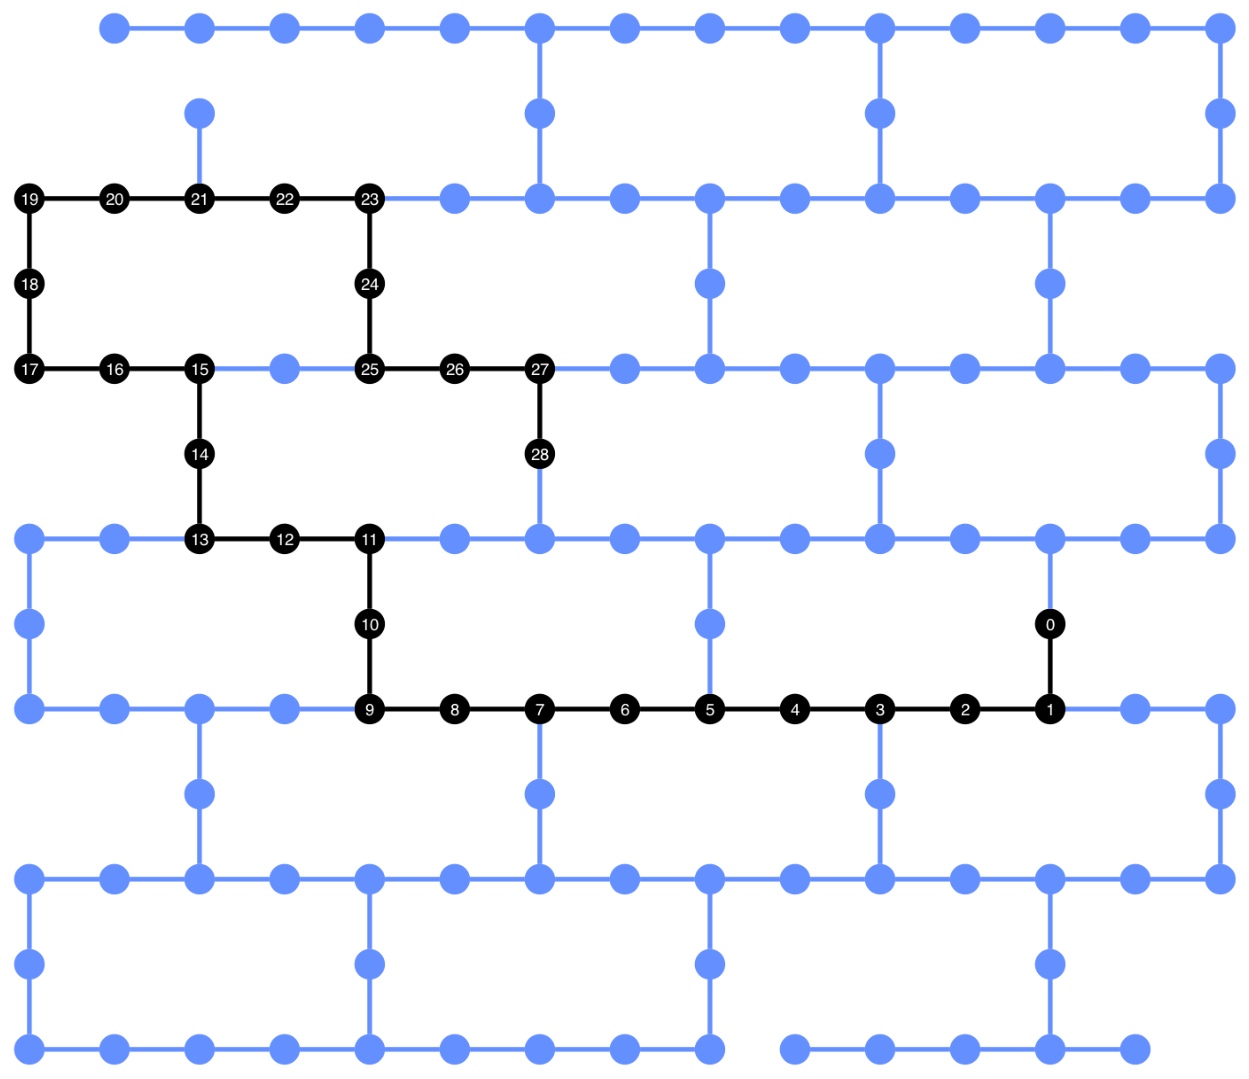

In [30]:
pass_manager = generate_preset_pass_manager(
        optimization_level=2,
        backend=backend,
        initial_layout= new_layout,
        coupling_map=CouplingMap(backend.configuration().coupling_map)
    )
transpiled_circ = pass_manager.run(qc)
print("depth",transpiled_circ.depth())
print("CNOT count",transpiled_circ.count_ops().get("cx", 0))
plot_circuit_layout(transpiled_circ, backend)

/var/folders/_9/dhlh8y415jx54r4xwjd06yp40000gq/T/ipykernel_12503/858685223.py:1: UserWarning: Providing `coupling_map` and/or `basis_gates` along with `backend` is not recommended, as this will invalidate the backend's gate durations and error rates.
  pass_manager = generate_preset_pass_manager(


depth 511
CNOT count 675


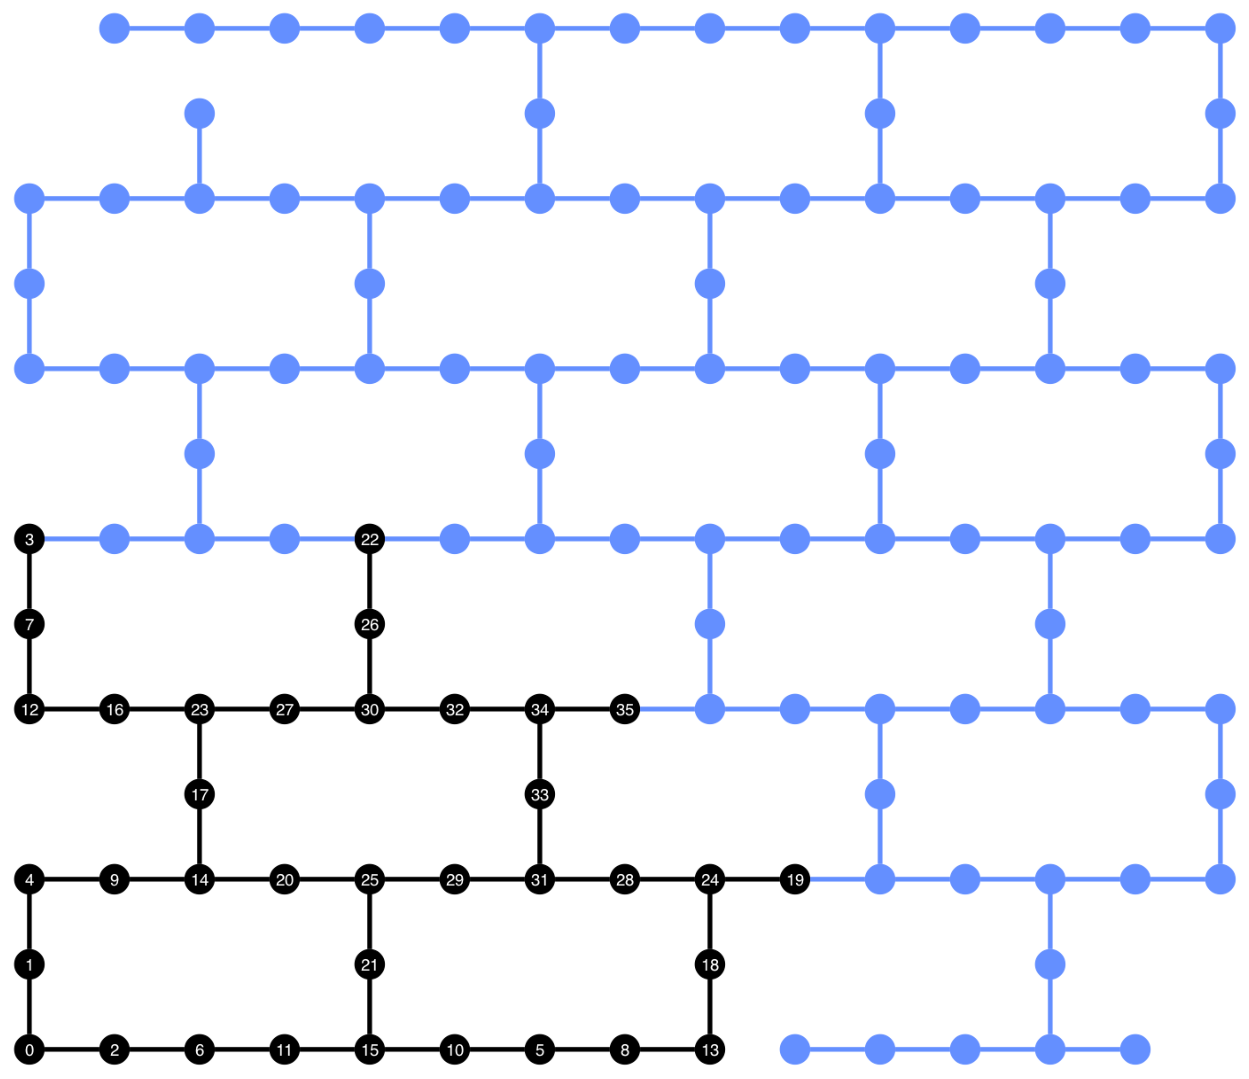

In [16]:
pass_manager = generate_preset_pass_manager(
        optimization_level=2,
        backend=backend,
        layout_method='dense',
        coupling_map=CouplingMap(backend.configuration().coupling_map)
    )
transpiled_circ = pass_manager.run(qc)
print("depth",transpiled_circ.depth())
print("CNOT count",transpiled_circ.count_ops().get("cx", 0))
plot_circuit_layout(transpiled_circ, backend)